# RNN training tutorial
### Adapted from the EEML2019 Tutorial on RNNs

The objective is to analyze the training of various RNNs on simple datasets and doing some analysis.

Structure:

  1. basic (vanilla RNN) implementation
  2. observing exploding/vanishing gradients
  
 Homework Assignment
  3. Training an RNN on character level langugage modelling task (e.g. Shakespeare Sonnet dataset) - char RNN
    * find an existing implementation, and adapt it to use LSTM cells and Vanilla RNN cells, playing with architectures  

Look for the questions after Sections 1 and 2. Provide your answers during the lab.

## Imports

In [8]:
#@title Imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import numpy as np
import seaborn as sns

import torch
import torch.nn as nn 


from matplotlib import pyplot as plt
  
sns.set_style('ticks')  


# Ex 1.    Vanilla RNN

Implement basic RNN cell using tf.layers.

   $$ h_t = f( Wx_t + Vh_{t-1}  + b) $$
   
   Where
   
   * $x_t$ input at time $t$
   * $h_t$ hidden state at time $t$
   * $W$ input-to-hidden mapping (trainable)
   * $V$ hidden-to-hidden mapping (trainable)
   * $b$ bias (trainable)
   * $f$ non-linearity chosen (usually tanh)

### Task 1.1 Implement Vanilla RNN Base recurrence model
$h_t = f(input + V h_(t-1) + b)$

In [9]:
class VanillaRNNBase(nn.Module):
  
    def __init__(self, hidden_size, activation=nn.Tanh, bias=True):    
        """
        Constructor for a simple RNNCell where the hidden-to-hidden transitions
        are defined by a linear layer and the default activation of `tanh` 
        :param hidden_size: the size of the hidden state
        :param activation: the activation function used for computing the next hidden state
        """
        super(VanillaRNNBase, self).__init__()
    
        self._hidden_size = hidden_size
        self._activation = activation()  
        self._bias = bias
            
        # TODO 1.1 Create the hidden-to-hidden layer
        # self._linear_hh = nn.Linear(...)
        self._linear_hh=nn.Linear(hidden_size,hidden_size,bias=bias)

    def forward(self, inputs, hidden=None):
        out = inputs
        #### TODO 1.1 Your code here
        ### ...
        #### end code
        if not (hidden is None):
            out+=self._linear_hh(hidden)
        out=self._activation(out)
        return out, out


class VanillaRNN(nn.Module):
    def __init__(self, input_size=1, output_size=1, hidden_size=20, bias=False):
        """
        Creates a vanilla RNN where input-to-hidden is a nn.Linear layer
        and hidden-to-output is a nn.Linear layer
        
        :param input_size: the size of the input to the RNN
        :param hidden_size: size of the hidden state of the RNN
        :param output_size: size of the output
        """
        super(VanillaRNN, self).__init__()
        
        self._input_size = input_size
        self._hidden_size = hidden_size
        self._output_size = output_size
        self._bias = bias
        
        self.in_to_hidden = nn.Linear(self._input_size, self._hidden_size, bias=self._bias)
        self.rnn_cell = VanillaRNNBase(self._hidden_size, bias=self._bias)
        self.hidden_to_out = nn.Linear(self._hidden_size, self._output_size, bias=self._bias) 
    
    def step(self, input, hidden=None):
        ### TODO 1.2 compute one step in the RNN
        ## input_ = ....
        ## _, hidden_ =  ....
        # output_ = ....
        input_=self.in_to_hidden(input)
        _,hidden_=self.rnn_cell(input_,hidden)
        output_=self.hidden_to_out(hidden_)
        return output_, hidden_
        
    
    def forward(self, inputs, hidden=None, force=True, warm_start=10):
        steps = len(inputs)
        
        outputs = torch.autograd.Variable(torch.zeros(steps, self._output_size, self._output_size))
        
        output_ = None
        hidden_ = hidden
        
        for i in range(steps):
            ## TODO 1.3 Implement forward pass in RNN
            ## Implement Teacher Forcing and Warm Start
            if i>=warm_start:
                input_=output_
            else:
                input_=inputs[i]
            
            if force: 
                input_=inputs[i]
            
            
            ### END Code
            
            output_, hidden_ = self.step(input_, hidden_)
            outputs[i] = output_
            
        return outputs, hidden_
        

## Train RNN on sine wave

Train the RNN on sine data - predict the next sine value from *predicted* sine values.

Predict   $$ sin (x +t \epsilon) $$ from $$ sin (x), sin (x + \epsilon), ..., sin (x + (t-1) \epsilon) $$

In particular, we want the network to predict the next value in a loop, conditioning the prediction on some initial values (provided) and all subsequent predictions.

To learn the prediction model, we will use *teacher forcing*. This means that when training the model, the input at time $t$ is the real sequence at time $t$, rather than the output produced by the model at $t-1$.

When we want to generate data from the model, we do not have access to the true sequence, so we do not use teacher forcing. However, in the case of our problem, we will also use *warm starting*, because we require multiple time steps to predict the next sine wave value (at least 2, for the initial value and for the step). 

The code below unrolls the RNN core you have defined above, does the training using backprop though time and plots the real data ("ground truth"), the data generated during training ("train predictions") and the model samples "generated".


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

Running code @ cuda


[200] avg_loss: 0.42152, report_loss: 0.41215, 


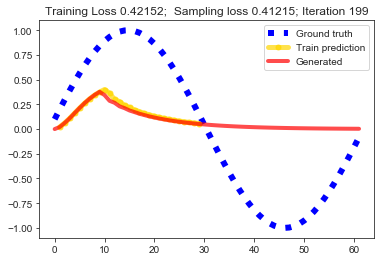

[400] avg_loss: 0.73924, report_loss: 0.43719, 


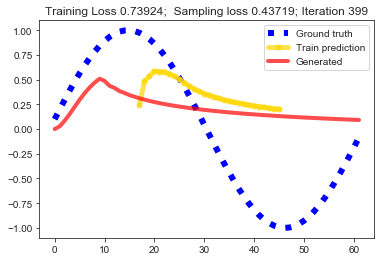

[600] avg_loss: 1.01765, report_loss: 0.39136, 


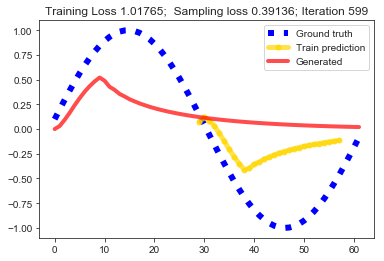

[800] avg_loss: 1.29806, report_loss: 0.42914, 


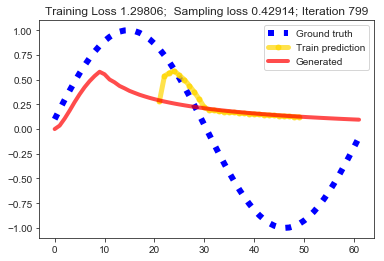

[1000] avg_loss: 1.58636, report_loss: 0.37453, 


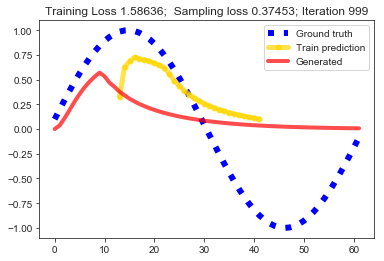

[1200] avg_loss: 1.84125, report_loss: 0.41016, 


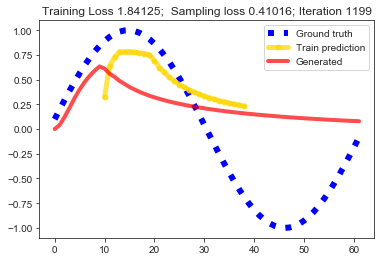

[1400] avg_loss: 2.08774, report_loss: 0.34136, 


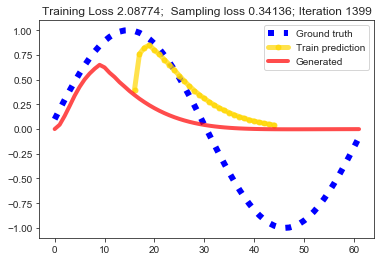

[1600] avg_loss: 2.25720, report_loss: 0.19132, 


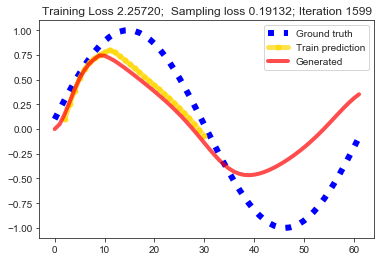

[1800] avg_loss: 2.32901, report_loss: 0.08745, 


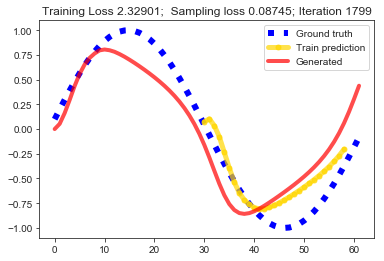

[2000] avg_loss: 2.38476, report_loss: 0.19875, 


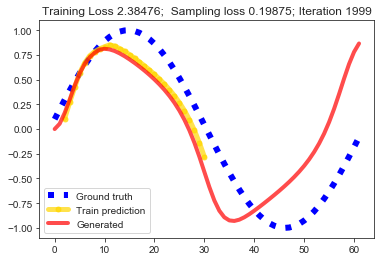

[2200] avg_loss: 2.43376, report_loss: 0.50326, 


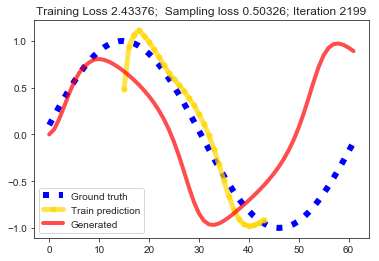

[2400] avg_loss: 2.48256, report_loss: 0.02822, 


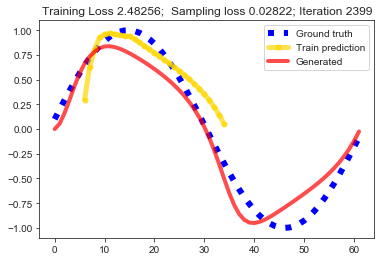

[2600] avg_loss: 2.53432, report_loss: 0.15399, 


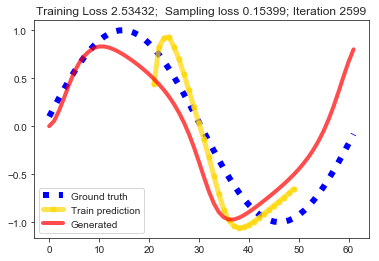

[2800] avg_loss: 2.57731, report_loss: 0.28631, 


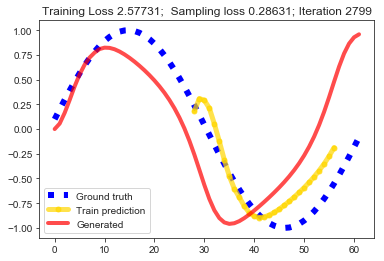

[3000] avg_loss: 2.62205, report_loss: 0.18302, 


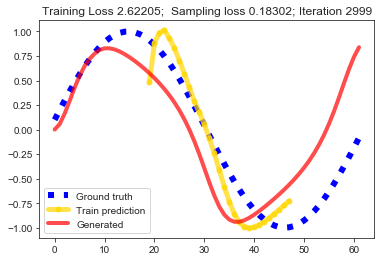

[3200] avg_loss: 2.66207, report_loss: 0.11536, 


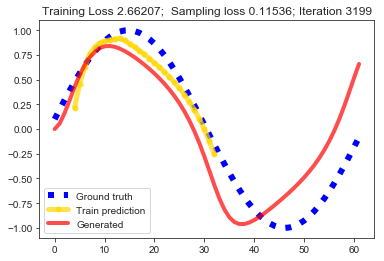

[3400] avg_loss: 2.70149, report_loss: 0.14885, 


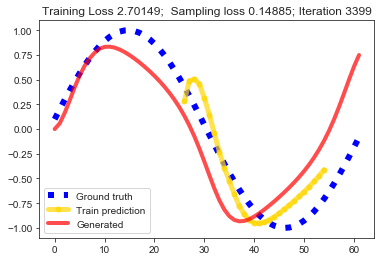

[3600] avg_loss: 2.73771, report_loss: 0.08448, 


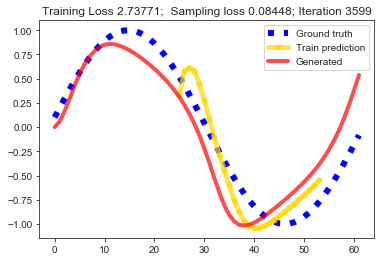

[3800] avg_loss: 2.77391, report_loss: 0.02377, 


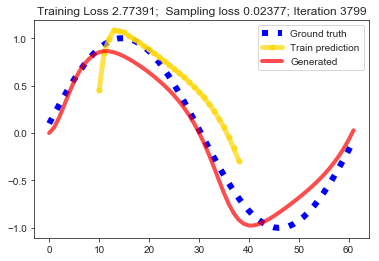

[4000] avg_loss: 2.80633, report_loss: 0.07100, 


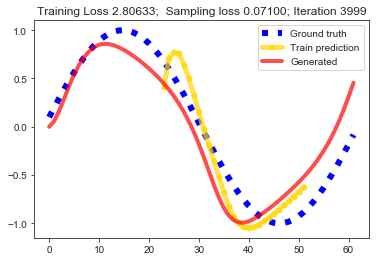

[4200] avg_loss: 2.84116, report_loss: 0.02365, 


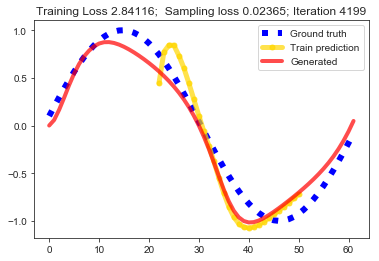

[4400] avg_loss: 2.87496, report_loss: 0.01077, 


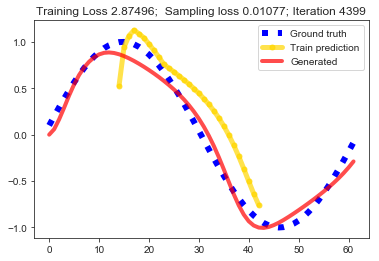

[4600] avg_loss: 2.90408, report_loss: 0.02133, 


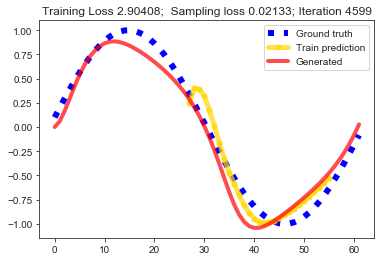

[4800] avg_loss: 2.93577, report_loss: 0.10519, 


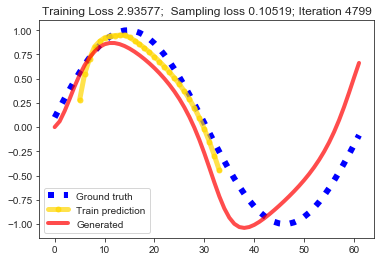

[5000] avg_loss: 2.96604, report_loss: 0.06275, 


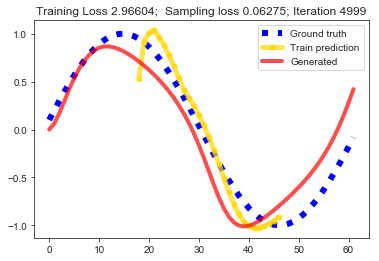

[5200] avg_loss: 2.99674, report_loss: 0.09870, 


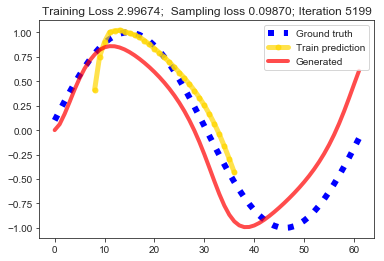

[5400] avg_loss: 3.02496, report_loss: 0.04896, 


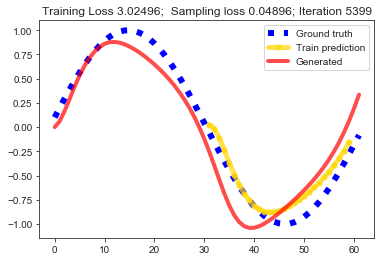

[5600] avg_loss: 3.05205, report_loss: 0.15169, 


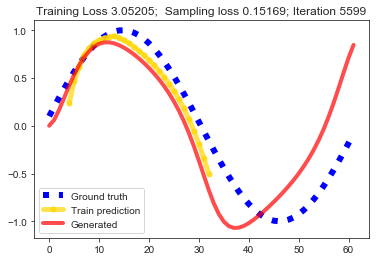

[5800] avg_loss: 3.08096, report_loss: 0.09623, 


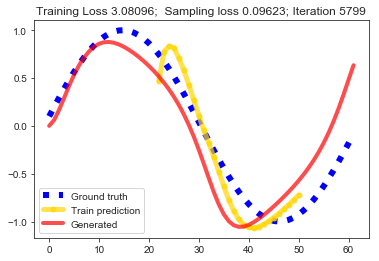

[6000] avg_loss: 3.10703, report_loss: 0.18135, 


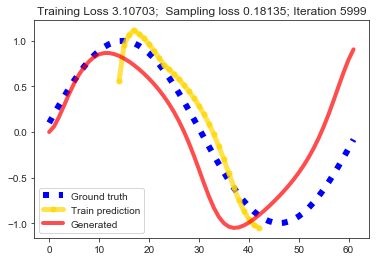

[6200] avg_loss: 3.13299, report_loss: 0.18959, 


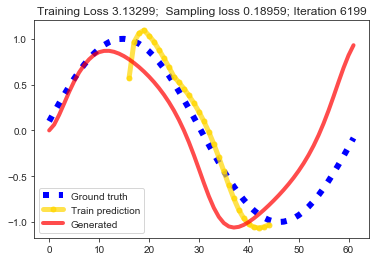

[6400] avg_loss: 3.15989, report_loss: 0.14732, 


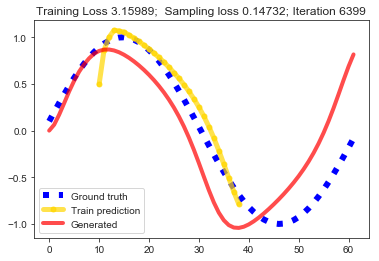

[6600] avg_loss: 3.18477, report_loss: 0.00980, 


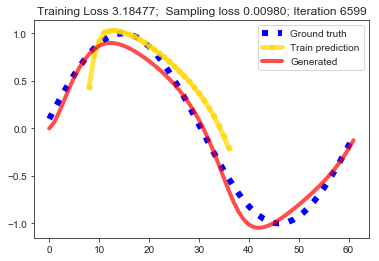

[6800] avg_loss: 3.20969, report_loss: 0.02442, 


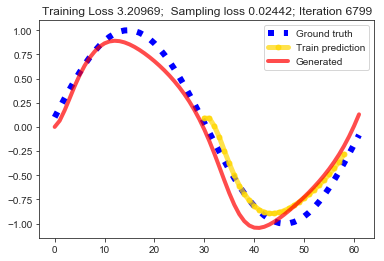

[7000] avg_loss: 3.23368, report_loss: 0.12439, 


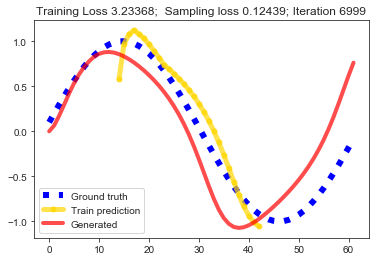

[7200] avg_loss: 3.25718, report_loss: 0.08544, 


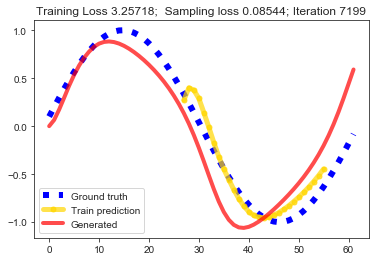

[7400] avg_loss: 3.28225, report_loss: 0.03325, 


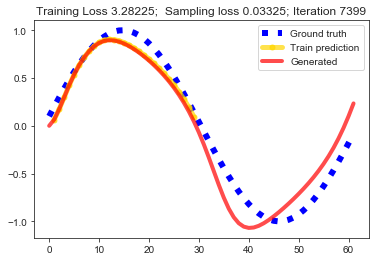

[7600] avg_loss: 3.30371, report_loss: 0.04531, 


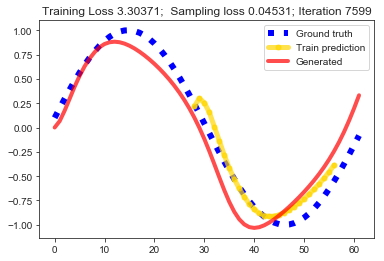

[7800] avg_loss: 3.32800, report_loss: 0.13774, 


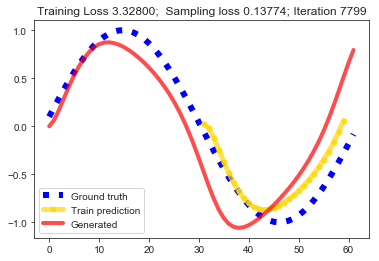

[8000] avg_loss: 3.35014, report_loss: 0.21956, 


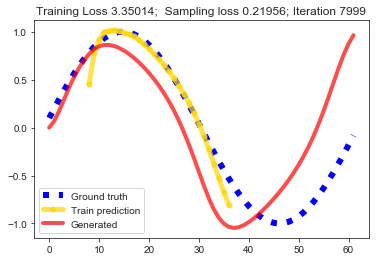

[8200] avg_loss: 3.37363, report_loss: 0.09678, 


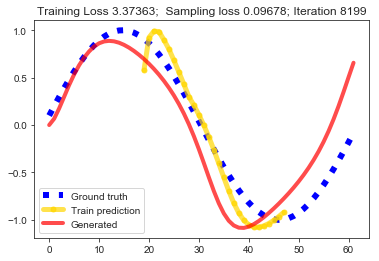

[8400] avg_loss: 3.39575, report_loss: 0.10364, 


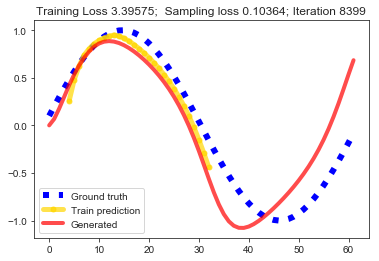

[8600] avg_loss: 3.41688, report_loss: 0.07867, 


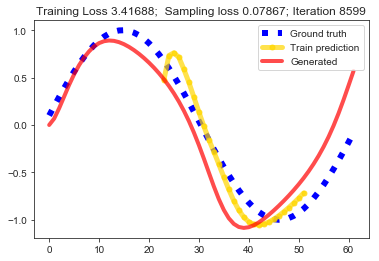

[8800] avg_loss: 3.43881, report_loss: 0.05896, 


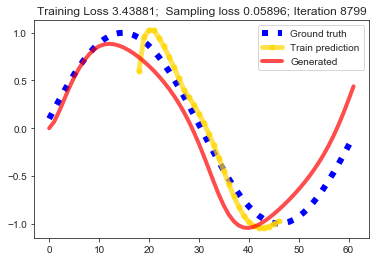

[9000] avg_loss: 3.45984, report_loss: 0.00867, 


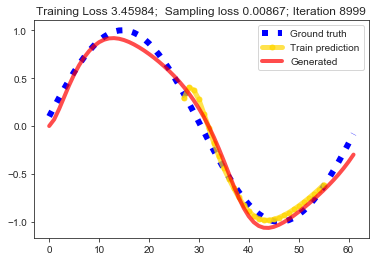

[9200] avg_loss: 3.48153, report_loss: 0.02392, 


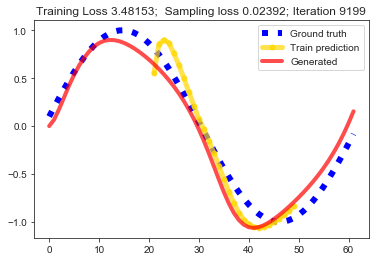

[9400] avg_loss: 3.50075, report_loss: 0.01477, 


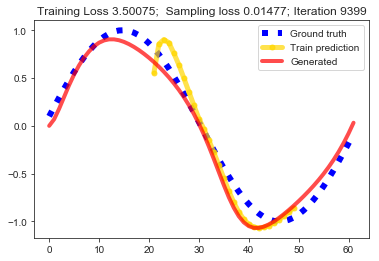

[9600] avg_loss: 3.51954, report_loss: 0.11027, 


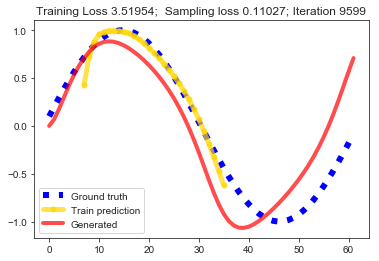

[9800] avg_loss: 3.54071, report_loss: 0.00738, 


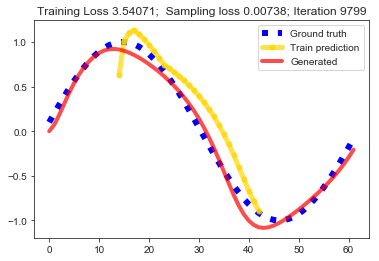

[10000] avg_loss: 3.56075, report_loss: 0.08808, 


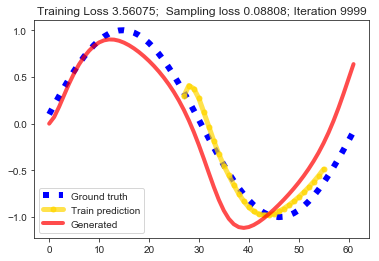

In [11]:
UNROLL_LENGTH = 30  #@param {type:"integer"}
NUM_ITERATIONS = 10000  #@param {type:"integer"}
WARM_START = 10  #@param {type:"integer"}
TEACHER_FORCING = False  #@param {type:"boolean"}
HIDDEN_UNITS = 20  #@param {type:"integer"}
LEARNING_RATE = 0.0001  #@param {type:"number"}
REPORTING_INTERVAL = 200  #@param {type:"integer"}

# We create training data, sine wave over [0, 2pi]
x_train = np.arange(0, 2*np.pi, 0.1).reshape(-1, 1, 1)
y_train = np.sin(x_train)

net = VanillaRNN(hidden_size=HIDDEN_UNITS, bias=False)
net.train()
net = net.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

running_loss = 0

for iteration in range(NUM_ITERATIONS):
    # select a start point in the training set for a sequence of UNROLL_LENGTH
    start = np.random.choice(range(x_train.shape[0] - UNROLL_LENGTH))
    train_sequence = y_train[start : (start + UNROLL_LENGTH)]
    
    train_inputs = torch.from_numpy(train_sequence[:-1]).float().to(device)
    train_targets = torch.from_numpy(train_sequence[1:]).float().to(device)
    
    optimizer.zero_grad()
    
    outputs, hidden = net(train_inputs, hidden=None, force=TEACHER_FORCING, warm_start=WARM_START)
    outputs = outputs.to(device)
    
    loss = criterion(outputs, train_targets)
    loss.backward()
    
    running_loss += loss.item()
    
    optimizer.step()
    
    if iteration % REPORTING_INTERVAL == REPORTING_INTERVAL - 1:
        # let's see how well we do on predictions for the whole sequence
        avg_loss = running_loss / REPORTING_INTERVAL
        
        report_sequence = torch.from_numpy(y_train[:-1]).float().to(device)
        report_targets = torch.from_numpy(y_train[1:]).float().to(device)
        report_output, report_hidden = net(report_sequence, hidden=None, force=False, warm_start=WARM_START)
 
        report_output = report_output.to(device)
    
        report_loss = criterion(report_output, report_targets)
        print('[%d] avg_loss: %.5f, report_loss: %.5f, ' % (iteration + 1, avg_loss, report_loss.item()))
        
        plt.figure()
        plt.title('Training Loss %.5f;  Sampling loss %.5f; Iteration %d' % (avg_loss, report_loss.item(), iteration))
        
        plt.plot(y_train[1:].ravel(), c='blue', label='Ground truth',
               linestyle=":", lw=6)
        plt.plot(range(start, start+UNROLL_LENGTH-1), outputs.cpu().data.numpy().ravel(), c='gold',
               label='Train prediction', lw=5, marker="o", markersize=5,
               alpha=0.7)
        plt.plot(report_output.cpu().data.numpy().ravel(), c='r', label='Generated', lw=4, alpha=0.7)
        plt.legend()
        plt.show()

In [ ]:
# Default hypers:
# UNROLL_LENGTH = 30  #@param {type:"integer"}
# NUM_ITERATIONS = 10000  #@param {type:"integer"}
# WARM_START = 2  #@param {type:"integer"}
# TEACHER_FORCING = False  #@param {type:"boolean"}
# HIDDEN_UNITS = 20  #@param {type:"integer"}
# LEARNING_RATE = 0.0001  #@param {type:"number"}
# REPORTING_INTERVAL = 2000  #@param {type:"integer"}

# You may want to try:
# default hypers with/without teacher forcing
# use UNROLL_LENGTH = 62 to train on the whole sequence (is teacher forcing useful?)
# use UNROLL_LENGTH = 62, no teacher forcing and warm_start = 2 # this should break training

**Note:** initialization is not fixed (we do not fix a random seed), so each time the cell is executed, the parameters take new initial values and hence training can lead to different results. What happens if you run it multiple times?

###What is worth trying/understanding here?

* Difference between teacher forcing and learning on own samples:
 * What are the pros and cons of teacher forcing?
 * Why is the model struggling to learn in one of the setups?
 * What is it we actually care about for models like this? What should be the actual surrogate?
* How does warm starting affect our training? Why?
* What happens if the structure of interest is much longer than the unroll length?

# Ex. 2      Vanishing and exploding gradients

Given an input sequence $(x_1, ..., x_N)$ of random floats (sampled from normal distribution), train an RNN as before and compute the gradients of the last output state w.r.t. every previous state:
$$
\left \| \frac{\partial h_{N}}{\partial h_i} \right \|
$$
for each unroll $i$, and plot these quantities for various RNNs.

Note, that during learning one would compute
$$
\frac{\partial L}{\partial \theta}  
$$
which, using chain rule will involve terms like
$$
\frac{\partial L}{\partial h_N} \cdot
\frac{\partial h_N}{\partial h_{N-1}} \cdot
\dots \cdot
\frac{\partial h_i}{\partial h_{i-1}} \cdot
\dots \cdot
\frac{\partial h_0}{\partial \theta}
$$
so if one of them vanishes, all of them do.

# Hints:

PyTorch already defines many types of RNN Cells, such as LSTM, GRU, etc.

NB: There is no training here, we are just computing the norms of the gradients of the last hidden state with respect to the hidden state across steps in the sequence.


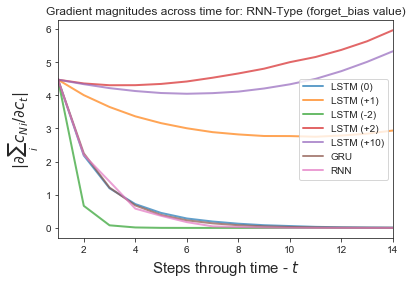

In [19]:
SEQ_LENGTH = 15  #@param {type:"integer"}
HIDDEN_UNITS = 20  #@param {type:"integer"}

dummy_input = [torch.from_numpy(np.array([[np.random.normal()]])) for _ in range(SEQ_LENGTH)] 

######################
#   YOUR CODE HERE   #
######################
# Add several cell constructors (use those already defined in Tensorflow) to the
# list (e.g., also add a GRU, and a few more LSTMS with their initial 
# forget_bias values set to: 0, +1, +2 and -2).
# If in doubt, check the documentation.

def _set_forget_bias(lstm_cell, fill_value=0.):
    # The bias terms in the lstm_cell are arranged as bias_input_gate, bias_forget_gate, bias_gain_gate, bias_output_gate
    # To alter the forget_gate bias, we need to modify the parameters from 1/4 to 1/2 of the length of the bias vectors
    for name, _ in lstm_cell.named_parameters():
        if "bias" in name:
            bias = getattr(lstm_cell, name)
            n = bias.size(0)
            start, end = n//4, n//2
            bias.data[start:end].fill_(float(fill_value))
            
    return lstm_cell


### Solution
rnn_types = {
    'LSTM (0)': lambda nhid:  _set_forget_bias(nn.modules.LSTMCell(input_size=1, hidden_size=nhid), fill_value=0.),
    ## TODO add several types of LSTM cells varying the forget gate bias - e.g. +1, -2, +2, +10
    'LSTM (+1)': lambda nhid:  _set_forget_bias(nn.modules.LSTMCell(input_size=1, hidden_size=nhid), fill_value=1.),
    'LSTM (-2)': lambda nhid:  _set_forget_bias(nn.modules.LSTMCell(input_size=1, hidden_size=nhid), fill_value=-2.),
    'LSTM (+2)': lambda nhid:  _set_forget_bias(nn.modules.LSTMCell(input_size=1, hidden_size=nhid), fill_value=2.),
    'LSTM (+10)': lambda nhid:  _set_forget_bias(nn.modules.LSTMCell(input_size=1, hidden_size=nhid), fill_value=10.),
    # add a GRUCell
    'GRU': lambda nhid: nn.modules.GRUCell(input_size=1,  hidden_size=nhid),
    # add our RNN module
    'RNN': lambda nhid: VanillaRNN(input_size=1, hidden_size=nhid),
}

depths = {rnn_type: [] for rnn_type in rnn_types}
grad_norms = {rnn_type: [] for rnn_type in rnn_types}

for rnn_type in rnn_types:
    
    # build RNN model
    constructor = rnn_types[rnn_type]
    rnn = constructor(HIDDEN_UNITS)
    
    # initialize gradients
    rnn.zero_grad()
    
    rnn_at_time = []
    gradients_at_time = []
    
    prev_state = None
    
    # pass the sequence through the RNN model
    for i in range(SEQ_LENGTH):
        ## Each RNN cell model has a different output, so switch after the defined type
        if prev_state is None:
            prev_state = rnn(dummy_input[i].float())
        else:
            if rnn_type.startswith('RNN'):
                prev_state = rnn(dummy_input[i].float(), hidden=prev_state[1])
            else:
                prev_state = rnn(dummy_input[i].float(), prev_state)
        
        ## We want to retain the gradient over the hidden state after each timestep (i.e. input of the sequence)
        if rnn_type.startswith('LSTM'):
            prev_state[1].retain_grad()  # for LSTMs the output is (h_t, c_t) . We call retain_grad() for c_t
            rnn_at_time.append(prev_state[1])
        
        ## GRUs and our RNN model have only one "hidden" output - h_t
        elif rnn_type.startswith('GRU'):
            prev_state.retain_grad()
            rnn_at_time.append(prev_state)
        
        elif rnn_type.startswith('RNN'):
            prev_state[1].retain_grad()
            rnn_at_time.append(prev_state[1])
    
    # We don't really care about the loss here: we are not solving a specific 
    # problem, any loss will work to inspect the behavior of the gradient.
    dummy_loss = torch.sum(rnn_at_time[-1])
    dummy_loss.backward()
    
    # collect all the gradients and plot them
    for i in range(1, SEQ_LENGTH):
        current_gradient = rnn_at_time[i].grad
        gradients_at_time.append(current_gradient)
    
    for gid, grad in enumerate(gradients_at_time):
        depths[rnn_type].append(len(gradients_at_time) - gid)    
        grad_norms[rnn_type].append(np.linalg.norm(grad))
        
    dummy_loss.detach_()

plt.figure()
for rnn_type in depths:
    plt.plot(depths[rnn_type], grad_norms[rnn_type], label="%s" % rnn_type, alpha=0.7, lw=2)
plt.legend()  
plt.ylabel("$ \\| \\partial \\sum_i {c_{N}}_i / \\partial c_t \\|$", fontsize=15)
plt.xlabel("Steps through time - $t$", fontsize=15)
plt.xlim((1, SEQ_LENGTH-1))
plt.title("Gradient magnitudes across time for: RNN-Type (forget_bias value)")
#plt.savefig("mygraph.png")
plt.show()


### What do we learn from this?

This particular experiment is an extremely simple surrogate for actual problem, but shows a few interesting aspects:

* Is LSTM by construction free of *exploding* gradients too?
* What are other ways of avoiding explosions you can think of?
* Does initialisation (of gates here, but in general) matter a lot?

See http://proceedings.mlr.press/v37/jozefowicz15.pdf for a more detailed discussion of the effect of the forget gate bias.

# Done.